In [1]:
# EXERCISE: Improve the accuracy of your model
# use the concept of multicollinearity and remove insignificant variables
# use a different method of scaling the numerical variables
# use a different ratio of train test split
# use the transformation on numerical columns which align it more towards a normal distribution

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

df = pd.read_csv("../lab-customer-analysis-round-5/files_for_lab/csv_files/marketing_customer_analysis.csv")
df.columns = [df.columns[col_name].lower().replace(' ','_') for col_name in range(len(df.columns))] # Standarize columns
df = df.set_index('customer')
df.head()

,state,customer_lifetime_value,response,coverage,education,effective_to_date,employmentstatus,gender,income,location_code,...,months_since_policy_inception,number_of_open_complaints,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size
customer,,,,,,,,,,,,,,,,,,,,,
BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,Suburban,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,Suburban,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,Suburban,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,Suburban,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,Rural,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [2]:
# X-y split

y = df['total_claim_amount']
X = df.drop(['total_claim_amount'], axis=1)

In [3]:
# Separate numerical and categorical values

X_num = df.select_dtypes(include='number')
X_cat = df.select_dtypes(exclude='number')

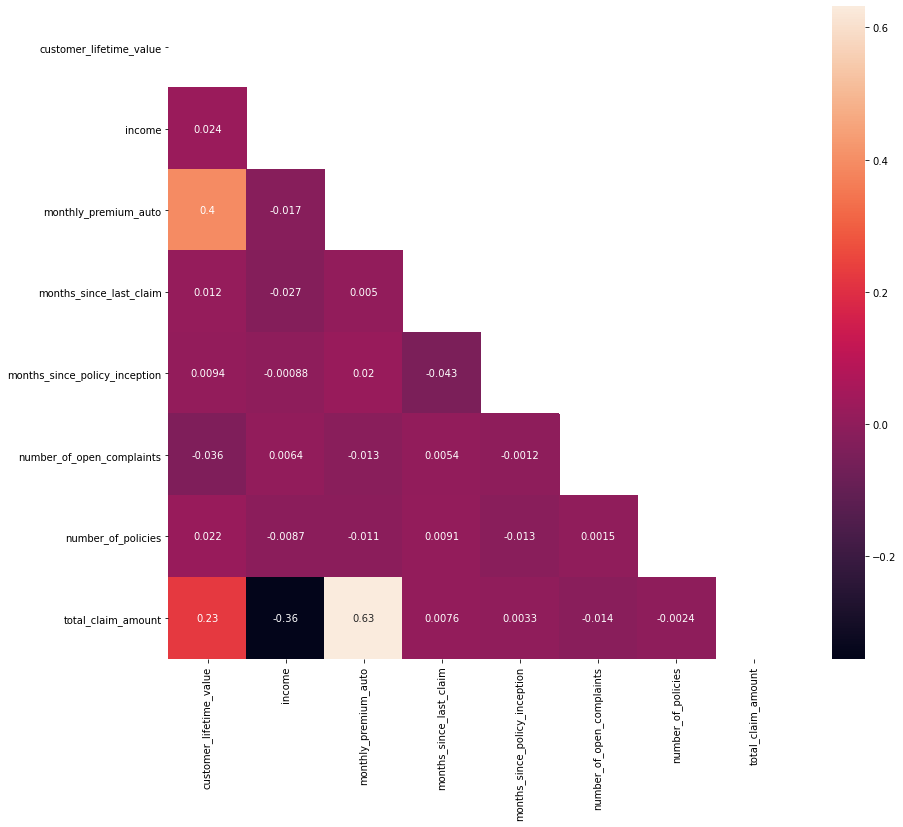

In [4]:
# EXERCISE: use the concept of multicollinearity and remove insignificant variables

corr_mat = X_num.corr(method='spearman')

mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask)] = True # Mask to hide the repeated half of the matrix

fig, ax = plt.subplots(figsize=(14, 12))
ax = sns.heatmap(X_num.corr(), mask=mask, annot=True)
plt.show() # No values show high correlation. Keep all columns.

In [25]:
X_num.columns

Index(['customer_lifetime_value', 'income', 'monthly_premium_auto',
       'months_since_last_claim', 'months_since_policy_inception',
       'number_of_open_complaints', 'number_of_policies',
       'total_claim_amount'],
      dtype='object')

In [26]:
X_num['income']

customer
BU79786    56274
QZ44356        0
AI49188    48767
WW63253        0
HB64268    43836
           ...  
LA72316    71941
PK87824    21604
TD14365        0
UP19263    21941
Y167826        0
Name: income, Length: 9134, dtype: int64

In [31]:
# MinMaxScaler
scaler = MinMaxScaler() # initialize MinMaxScaler assigning it to a variable

In [32]:
scaler.fit(X_num) # fit the numerical data to compute the minimum and maximum to be used for later scaling

MinMaxScaler()

In [33]:
scaler.data_max_

array([8.33253812e+04, 9.99810000e+04, 2.98000000e+02, 3.50000000e+01,
       9.90000000e+01, 5.00000000e+00, 9.00000000e+00, 2.89323968e+03])

In [5]:
# Normalize (numerical)

def boxcox_transform(df):
    numeric_cols = df.select_dtypes(np.number).columns
    _ci = {column: None for column in numeric_cols}
    for column in numeric_cols:
        # since i know any columns should take negative numbers, to avoid -inf in df
        df[column] = np.where(df[column]<=0, np.NAN, df[column])
        df[column] = df[column].fillna(df[column].mean())
        transformed_data, ci = stats.boxcox(df[column]) 
        df[column] = transformed_data
        _ci[column] = [ci] 
    return df, _ci

X_num_trans, _ci = boxcox_transform(X_num.copy()) #IMPORTANT: use copy method
X_num_trans

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount
customer,,,,,,,,
BU79786,2.703839,1247.937066,0.685347,10.876059,3.017887,0.648045,0.000000,33.035752
QZ44356,2.754926,1167.961720,0.685871,5.808248,18.780377,0.648045,1.424359,56.357614
AI49188,2.780772,1144.063081,0.686039,7.347815,17.389171,0.648045,0.607328,40.071789
WW63253,2.759125,1167.961720,0.686018,7.347815,26.160800,0.648045,1.363462,38.763252
HB64268,2.704995,1072.375744,0.685461,5.471294,19.461641,0.648045,0.000000,19.560154
...,...,...,...,...,...,...,...,...
LA72316,2.801170,1448.531450,0.685461,7.347815,33.090025,0.648045,0.607328,23.588905
PK87824,2.711030,697.790558,0.685606,6.134207,13.709541,0.648045,0.000000,32.792951
TD14365,2.762062,1167.961720,0.685725,4.379465,17.034934,1.176115,0.607328,47.263726


In [6]:
# Function to remove outliers

def remove_outliers(df, threshold=1.5, in_columns=df.select_dtypes(np.number).columns, skip_columns=[]):
    for column in in_columns:
        if column not in skip_columns:
            upper = np.percentile(df[column],75)
            lower = np.percentile(df[column],25)
            iqr = upper - lower
            upper_limit = upper + threshold * iqr
            lower_limit = lower - threshold * iqr
            df = df[(df[column]>lower_limit) & (df[column]<upper_limit)]
    return df

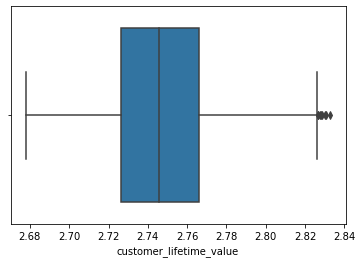

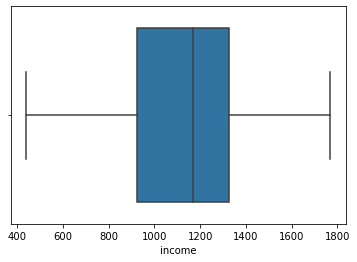

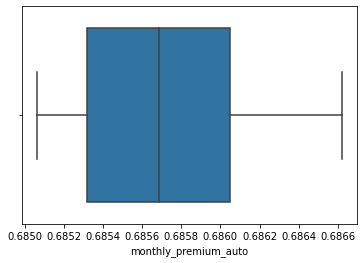

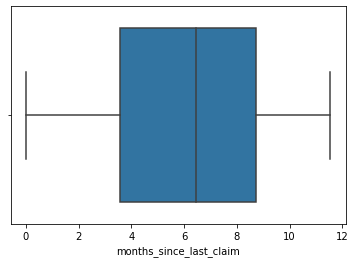

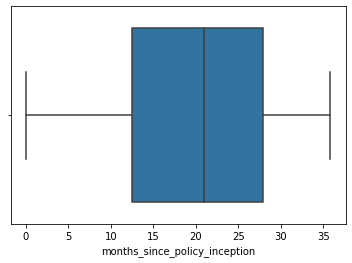

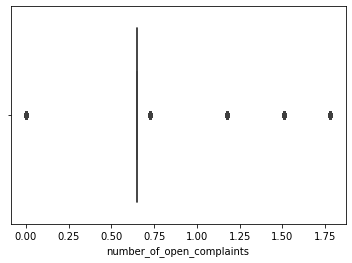

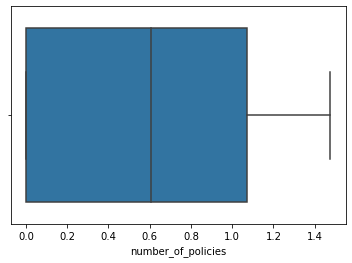

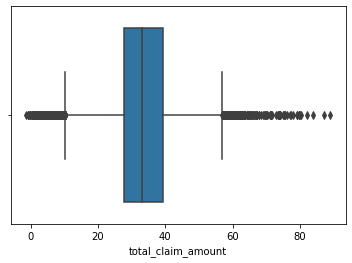

In [7]:
# Ajust the whis parameter to identify outliers (standard is 1.5)

for col in X_num_trans:
    sns.boxplot(x = X_num_trans[col])#, whis=2.5)
    plt.show()

In [8]:
# Remove outliers, but try not to reduce the data too much.
# Play with the parameters to see, so after a better analysis we can choose which columns to drop outliers or not

X_num_clean = X_num_trans.copy()

X_num_clean = remove_outliers(X_num_clean, in_columns=['customer_lifetime_value'])
X_num_clean = remove_outliers(X_num_clean, threshold=2.5, in_columns=['total_claim_amount'])

In [9]:
# One Hot/Label Encoding (categorical)

X_cat_encoded = pd.get_dummies(X_cat, drop_first=True)
X_cat_encoded

,state_California,state_Nevada,state_Oregon,state_Washington,response_Yes,coverage_Extended,coverage_Premium,education_College,education_Doctor,education_High School or Below,...,sales_channel_Branch,sales_channel_Call Center,sales_channel_Web,vehicle_class_Luxury Car,vehicle_class_Luxury SUV,vehicle_class_SUV,vehicle_class_Sports Car,vehicle_class_Two-Door Car,vehicle_size_Medsize,vehicle_size_Small
customer,,,,,,,,,,,,,,,,,,,,,
BU79786,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
QZ44356,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
AI49188,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
WW63253,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
HB64268,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LA72316,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
PK87824,1,0,0,0,1,1,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
TD14365,1,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [14]:
# Concat DataFrames

#X_ready = pd.concat([X_num_trans, X_cat_encoded], axis=1) # With outliers
X_ready = pd.concat([X_num_clean, X_cat_encoded], axis=1) # Without outliers
X_ready

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount,state_California,state_Nevada,...,sales_channel_Branch,sales_channel_Call Center,sales_channel_Web,vehicle_class_Luxury Car,vehicle_class_Luxury SUV,vehicle_class_SUV,vehicle_class_Sports Car,vehicle_class_Two-Door Car,vehicle_size_Medsize,vehicle_size_Small
customer,,,,,,,,,,,,,,,,,,,,,
BU79786,2.703839,1247.937066,0.685347,10.876059,3.017887,0.648045,0.000000,33.035752,0,0,...,0,0,0,0,0,0,0,1,1,0
QZ44356,2.754926,1167.961720,0.685871,5.808248,18.780377,0.648045,1.424359,56.357614,0,0,...,0,0,0,0,0,0,0,0,1,0
AI49188,2.780772,1144.063081,0.686039,7.347815,17.389171,0.648045,0.607328,40.071789,0,1,...,0,0,0,0,0,0,0,1,1,0
WW63253,2.759125,1167.961720,0.686018,7.347815,26.160800,0.648045,1.363462,38.763252,1,0,...,0,1,0,0,0,1,0,0,1,0
HB64268,2.704995,1072.375744,0.685461,5.471294,19.461641,0.648045,0.000000,19.560154,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LA72316,2.801170,1448.531450,0.685461,7.347815,33.090025,0.648045,0.607328,23.588905,1,0,...,0,0,1,0,0,0,0,0,1,0
PK87824,2.711030,697.790558,0.685606,6.134207,13.709541,0.648045,0.000000,32.792951,1,0,...,1,0,0,0,0,0,0,0,1,0
TD14365,2.762062,1167.961720,0.685725,4.379465,17.034934,1.176115,0.607328,47.263726,1,0,...,1,0,0,0,0,0,0,0,1,0


In [15]:
# Train-test split: play with different train-test ratios

X_train, X_test, y_train, y_test = train_test_split(X_ready, y, test_size=0.20, random_state=42)

ValueError: Found input variables with inconsistent numbers of samples: [9083, 9134]

In [ ]:
# Apply linear regression

model = LinearRegression()
model.fit(X_train,y_train)

In [ ]:
# EXERCISE: Model validation

prediction = model.predict(X_test)

R2 = r2_score(y_test, prediction)
MSE = mean_squared_error(y_test, prediction, squared=True)
RMSE = mean_squared_error(y_test, prediction, squared=False)
MAE = mean_absolute_error(y_test, prediction)

print("R2:", round(R2,2))
print("MSE:", round(MSE,2))
print("RMSE:", round(RMSE,2))
print("MAE:", round(MAE,2))